### imports

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

### get data and organize it

In [2]:
iris = sns.load_dataset("iris")

# organize data
data = torch.tensor(iris[iris.columns[0:4]].values, dtype=torch.float32)
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species == "setosa"] = 0
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2
# print(labels)

In [3]:
# making train and test sets using sklearn
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2
)
# convert them into pytorch datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

In [4]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    return train_loader, test_loader

### function to create model

In [5]:
def create_model(lr=0.001):
    # ANN and parameters
    ANNiris = nn.Sequential(
        nn.Linear(4, 64),  # input layer
        nn.ReLU(),  # activation function
        nn.Linear(64, 64),  # hidden layer
        nn.ReLU(),  # activation function
        nn.Linear(64, 3),  # output layer
    )
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=lr)  # optimizer
    lossFun = nn.CrossEntropyLoss()  # loss function includes softmax as well
    return ANNiris, optimizer, lossFun

### function to train the model

In [6]:
def train(ANNiris, optimizer, lossFun, train_loader, test_loader, epochs=100):
    # training
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)

    for epoch in range(epochs):
        # train in batches
        batchacc = []
        for data, labels in train_loader:
            # forward pass
            output = ANNiris(data)

            # compute loss
            loss = lossFun(output, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy
            predLabel = torch.argmax(output, axis=1)
            batchacc.append(torch.mean((predLabel == labels).float()) * 100)

        # train accuracy
        train_acc[epoch] = np.mean(batchacc)

        # test accuracy
        with torch.no_grad():
            test_data, test_label = test_loader.dataset.tensors
            pred = ANNiris(test_data)
            predLabel = torch.argmax(pred, axis=1)
            test_acc[epoch] = torch.mean((predLabel == test_label).float()) * 100

    return train_acc, test_acc

### experiment

In [7]:
# smoothing function
def smooth(x, k):
    return np.convolve(x, np.ones(k) / k, mode="same")

# expiriment batch sizes
epochs = 100
batch_sizes = [1, 2, 4, 8, 16, 32, 64]
results_train_acc = np.zeros((len(batch_sizes), epochs))
results_test_acc = np.zeros((len(batch_sizes), epochs))
for i, batch_size in enumerate(batch_sizes):
    train_loader, test_loader = create_dataloaders(batch_size)
    ANNiris, optimizer, lossFun = create_model()
    train_acc, test_acc = train(ANNiris, optimizer, lossFun, train_loader, test_loader, epochs)
    results_train_acc[i] = smooth(train_acc, 5)
    results_test_acc[i] = smooth(test_acc, 5)
    print(f"batch size: {batch_size}, train accuracy: {train_acc[-1]:.2f}")

batch size: 1, train accuracy: 97.50
batch size: 2, train accuracy: 95.00
batch size: 4, train accuracy: 95.00
batch size: 8, train accuracy: 88.33
batch size: 16, train accuracy: 67.86
batch size: 32, train accuracy: 35.42
batch size: 64, train accuracy: 34.38


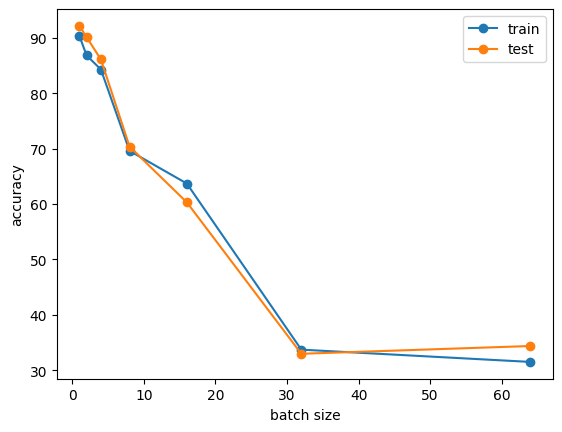

In [8]:
# plot batch size vs mean accuracy
plt.plot(batch_sizes, np.mean(results_train_acc, axis=1), label="train", marker="o")
plt.plot(batch_sizes, np.mean(results_test_acc, axis=1), label="test", marker="o")
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.legend()
plt.show()

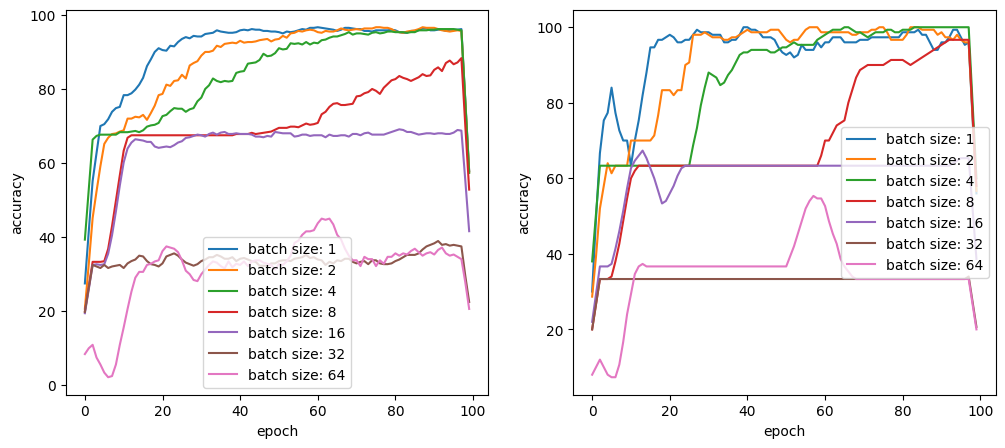

In [11]:
# plot batch size vs accuracy for each epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(epochs), results_train_acc[i], label=f"batch size: {batch_size}")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

# plot for test
plt.subplot(1, 2, 2)
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(epochs), results_test_acc[i], label=f"batch size: {batch_size}")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()